In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from os import path
from quenching import fit_quenching_linear_unitless, calc_quenched_flour, mark_non_quenchers
from quenching import well_mean_with_error_propagation

In [2]:
# Load data from in-vitro RTDP plate reader experiments. 
long_df_pre = pd.read_csv('../data/RTDP_supes/RTDP_long_df_pre.csv', index_col=0)
long_df_post = pd.read_csv('../data/RTDP_supes/RTDP_long_df_post.csv', index_col=0)

# Drop first timepoint so that the measurement has stabilized.
long_df_pre = long_df_pre[long_df_pre.time_s > 0]
long_df_post = long_df_post[long_df_post.time_s > 0]

# Infer the quenched fluorescence by comparing pre/post measurements
long_df_pre, long_df_post, blank_vals, rtdp_alone_fluors = calc_quenched_flour(
    long_df_pre, long_df_post, "rtdp_fluor", "RTDP")

# In this case data comes from a single date, so there is only one blank (mean+/-std) and reference value.
blank_val = blank_vals.iloc[0]
rtdp_alone_fluor = rtdp_alone_fluors.iloc[0]

long_df_pre.to_csv("../data/RTDP_supes/RTDP_long_df_pre_processed.csv")
long_df_post.to_csv("../data/RTDP_supes/RTDP_long_df_post_processed.csv")

print("blank", blank_val)
print("RTDP in buffer", rtdp_alone_fluor)
cv = rtdp_alone_fluor.std_dev/rtdp_alone_fluor.nominal_value
print("CV of RTDP in buffer {0:.2f}%".format(100*cv))

blank 1.01+/-0.12
RTDP in buffer (4.17+/-0.15)e+03
CV of RTDP in buffer 3.70%


In [3]:
# Peek at the data
long_df_post.head()

,index,time_s,well,rtdp_fluor,concentration,fold_dilution,media,name,replicate,plate,...,blanked_rtdp_fluor,expected_blanked_rtdp_fluor,estimated_true_rtdp_fluor,F0_F_ratio,F_F0_ratio,u_blanked_rtdp_fluor,u_expected_blanked_rtdp_fluor,u_estimated_true_rtdp_fluor,u_F0_F_ratio,u_F_F0_ratio
1,1,74.679,A1,1696,0.990099,1,MM noC,PA14 WT,1,1,...,1694.986111,4218.660160,1644.548173,2.534570,0.394544,0.117851,154.176835,0.011679,0.093750,0.014594
2,2,149.361,A1,1695,0.990099,1,MM noC,PA14 WT,1,1,...,1693.986111,4218.660160,1643.548173,2.536112,0.394304,0.117851,154.176835,0.011679,0.093807,0.014585
3,3,224.037,A1,1692,0.990099,1,MM noC,PA14 WT,1,1,...,1690.986111,4218.660160,1640.548173,2.540750,0.393585,0.117851,154.176835,0.011679,0.093979,0.014558
5,5,74.679,A2,2142,0.495050,2,MM noC,PA14 WT,1,1,...,2140.986111,4195.236737,2113.971597,1.971749,0.507164,0.117851,154.176835,0.011679,0.072932,0.018759
6,6,149.361,A2,2143,0.495050,2,MM noC,PA14 WT,1,1,...,2141.986111,4195.236737,2114.971597,1.970817,0.507404,0.117851,154.176835,0.011679,0.072898,0.018768


In [4]:
means_pre_by_rep = well_mean_with_error_propagation(long_df_pre, "rtdp_fluor", rtdp_alone_fluor)
means_post_by_rep = well_mean_with_error_propagation(long_df_post, "rtdp_fluor", rtdp_alone_fluor)
means_pre_by_rep.to_csv("../data/RTDP_supes/mean_rtdp_fluor_pre.csv")
means_post_by_rep.to_csv("../data/RTDP_supes/mean_rtdp_fluor_post.csv")

In [5]:
# calculate the KSV values for RTDP + various molecules by fitting to the linear form of 
# the Stern-Volmer model of equilibrium quenching. 
# See Gehlen J. Photochem. Photobio. 2020 for summary and Szabo J Phys Chem 1989 for derivations. 

name_mask = long_df_post.media == 'MM noC'
sub_post_df = long_df_post[name_mask]
name_order = sorted(
    set(sub_post_df.name.unique()).difference('BLANK,RTDP'.split(',')))
print(name_order)
quencher_fit_df = fit_quenching_linear_unitless(means_post_by_rep.reset_index(), name_order)

# Molecules are called non-quenchers if quenching is only weakly correlated with their
# concentrations or, alternatively, if the degree of quenching is low enought to be 
# consistent with no quenching at all, i.e. if it cannot be distinguished from the 
# variance of the signal of sensor (RTDP here) in buffer. 
print("Minimum effect size (CV of RTDP alone): {0:.2g}".format(cv))
quencher_fit_df = mark_non_quenchers(quencher_fit_df, min_effect_size=cv)

# Save the fits
quencher_fit_df.to_csv("../data/RTDP_supes/fits.csv")
quencher_fit_df

['BG WT', 'BG dtox', 'EC WT', 'PA14 WT', 'PA14 dphz', 'PA14 dphz dside', 'PA14 dside']
Fitting BG WT
	F0/F ~ [BG WT] with R = 0.727
	Data for 6 concentrations
Fitting BG dtox
	F0/F ~ [BG dtox] with R = 0.778
	Data for 6 concentrations
Fitting EC WT
	F0/F ~ [EC WT] with R = 0.203
	Data for 6 concentrations
Fitting PA14 WT
	F0/F ~ [PA14 WT] with R = 0.982
	Data for 6 concentrations
Fitting PA14 dphz
	F0/F ~ [PA14 dphz] with R = 0.853
	Data for 6 concentrations
Fitting PA14 dphz dside
	F0/F ~ [PA14 dphz dside] with R = 0.760
	Data for 6 concentrations
Fitting PA14 dside
	F0/F ~ [PA14 dside] with R = 0.749
	Data for 6 concentrations
Minimum effect size (CV of RTDP alone): 0.037


,name,K_SV,K_SV err,R,N_concs,quencher
0,BG WT,0.343594,0.040006,0.726718,6,True
1,BG dtox,0.321534,0.040258,0.777879,6,True
2,EC WT,0.167852,0.037442,0.203406,6,False
3,PA14 WT,1.730844,0.072305,0.982200,6,True
4,PA14 dphz,0.646754,0.047091,0.853182,6,True
5,PA14 dphz dside,0.671878,0.048049,0.760410,6,True
6,PA14 dside,0.840698,0.050380,0.749364,6,True


All is now preprocessed, fit and exported. 
Everything below here is just exploring the data.

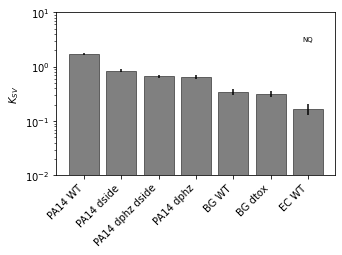

In [6]:
# Take a peek at the linear KSV fits. 
# Index fits by name for easier lookup
rtdp_fits = quencher_fit_df.set_index('name').sort_values('K_SV', ascending=False)

# Some of the better quenchers, e.g. toxoflavin, give a non-linear response curve as expected from theory. 
# However, the non-linear model has an additional degree of freedom, so it gives much larger errors in the KSV value.
# As such it makes more sense to report value +/- error for the linear model and discuss the non-linearity in the SI.
xs = np.arange(rtdp_fits.index.size)
ys = rtdp_fits['K_SV']
yerr = rtdp_fits['K_SV err']

plt.figure(figsize=(5,3))
plt.yscale('log')
plt.bar(xs, ys, yerr=yerr, color='grey', edgecolor='k', lw=0.5, ecolor='k')

for i, (idx, row) in enumerate(rtdp_fits.iterrows()):
    if not row.quencher:
        plt.text(i, 3, 'NQ', ha='center', fontsize=7)
    
plt.ylim(1e-2, 10)
plt.ylabel('$K_{SV}$')
plt.xticks(xs, rtdp_fits.index, rotation=45, ha='right')
plt.show()

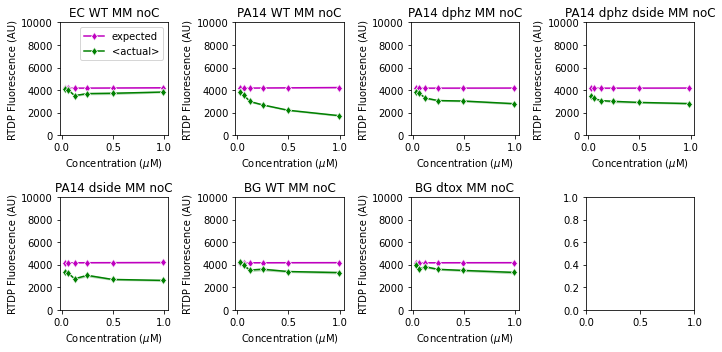

In [7]:
fig, axs = plt.subplots(figsize=(10,5), ncols=4, nrows=2)
flat_axs = axs.flatten()
name_order = ['EC WT', 'PA14 WT', 'PA14 dphz', 'PA14 dphz dside', 'PA14 dside', 'BG WT', 'BG dtox']

for i, media in enumerate(long_df_post.media.unique()):
    for j, qname in enumerate(name_order):
        my_ax = flat_axs[8*i + j]
        plt.sca(my_ax)
        
        mask = np.logical_and(
            long_df_post.name == qname, long_df_post.media == media)
        qdf_post = long_df_post[mask]

        sns.lineplot(data=qdf_post, x='concentration', y='expected_blanked_rtdp_fluor', 
                     color='m', marker='d', markersize=6, label='expected')

        sns.lineplot(data=qdf_post, x='concentration', y='blanked_rtdp_fluor', 
                     color='g', marker='d', markersize=6, 
                     label='<actual>')

        plt.title('{0} {1}'.format(qname, media))
        plt.ylim(0, 10000)
        plt.xlabel('Concentration ($\mu$M)')
        plt.ylabel('RTDP Fluorescence (AU)')

        if j > 0:
            plt.legend().set_visible(False)
    
plt.tight_layout()
plt.show()

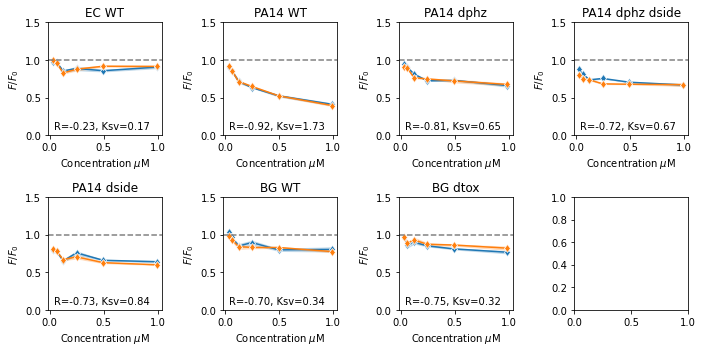

In [8]:
fig, axs = plt.subplots(figsize=(10,5), ncols=4, nrows=2)
flat_axs = axs.flatten()
name_order = ['EC WT', 'PA14 WT', 'PA14 dphz', 'PA14 dphz dside', 'PA14 dside', 'BG WT', 'BG dtox']

for i, media in enumerate(long_df_post.media.unique()):
    for j, qname in enumerate(name_order):
        my_ax = flat_axs[8*i + j]
        plt.sca(my_ax)
        
        mask = np.logical_and(
            long_df_post.name == qname, long_df_post.media == media)
        qdf_post = long_df_post[mask]

        sns.lineplot(data=qdf_post, x='concentration', y='F_F0_ratio', 
                     color='m', marker='d', markersize=6,
                     hue=qdf_post[['date', 'replicate']].apply(tuple, axis=1),
                     legend=False)

        corr = qdf_post.corr().loc['concentration', 'F_F0_ratio']
        slope = rtdp_fits.loc[qname]['K_SV']
        plt.text(0.05, 0.05, 'R={0:.2f}, Ksv={1:0.2f}'.format(corr, slope),
                 transform=my_ax.transAxes)
        plt.axhline(1, ls='--', color='grey')

        plt.title(qname)
        plt.ylim(0, 1.5)
        plt.xlabel('Concentration $\mu$M')
        plt.ylabel('$F / F_0$')
    
plt.tight_layout()
plt.show()